## DuneAI segmentation in XNAT

In [1]:
# First, run the following command from terminal: 
# /workspace/admin/envs/duneai/etc/activate.d/init.sh
# then select 'duneai' kernel from available kernels. Restart notebook if not listed.

### 1. Configure and analyze project directories

Put XNAT project name where your data resides here. Also some configuration file locations are set here. Intermediate configuration files will be written to your workspace directory/{Project}. 

In [2]:
import os, subprocess, sys
#local imports
pymipl_path = os.path.abspath(os.path.join('../../','pymipl'))
sys.path.append(pymipl_path)
from dicom_sort import *
from pathlib import Path

In [3]:
import os, subprocess, sys
#local imports
pymipl_path = os.path.abspath(os.path.join('../../','pymipl'))
sys.path.append(pymipl_path)
from dicom_sort import *
from pathlib import Path

#set to True to regenerate project directory structure saved in local json file.
rebuild_directory_structure=False

#XNAT project label
project='RIDER-LUNG-CT'

#Persistent workspace root path
root_dir=Path("/workspace/admin")

outdir=root_dir / project
xnat_project_path=f'/data/projects/{project}/experiments'
directory_structure_file=outdir / "project_dir_structure.json"
xnat_structure_file=outdir / "xnat_structure.json"




### 2. Scan mounted project directory
Project structure, with all DICOM scans and segmentations, is written to  configuration files in workspace project location.


In [4]:

if rebuild_directory_structure:
    d=analyze_dir(xnat_project_path,directory_structure_file)
else:
    with open(directory_structure_file, 'r') as file:
        d = json.load(file)
        
subjects=reindex_to_structurals_and_segs(d,xnat_structure_file)

### 2. Detect structural CT scans in data.
Build a list of structural CT scans in project.


In [5]:
from pathlib import Path
ct_scans=[]
for exp in d['children']:
    #print (Path(exp['path']).stem)
    exp_label=Path(exp['path']).stem
    for subdir1 in exp['children']:
        if Path(subdir1['path']).stem == 'SCANS': 
            #print(subdir1['path'])
            for scan in subdir1['children']:
                scan_label=Path(scan['path']).stem
                #print (scan_label)
                try:
                    #print(scan['children'][0]['children'][0]['SOPClass'])
                    if scan['children'][0]['children'][0]['SOPClass']=='CTImageStorage':
                        #print('CT image:', scan_label)
                        ct_scans+=[scan['children'][0]['children'][0]]
                except Exception as e:
                    pass
                    
print(f'number of scans: {len(ct_scans)}')
                    

number of scans: 59


### 3. Create batch file.
This creates batch files to run on experiment specific containers. Set flags in the beginning to control execution.

Performs the following:
1. convert strcutrual DICOM's to NIFTI
2. convert existing segmentations, if any, to NIFTI
3. run AI segmentation
4. generate QC images
5. compute Dice coefficients.

The batch file is then run outside of this notebook by external containers.

In [8]:
import datetime

#set to True to convert structurals to NIFTI
structural2nifti=True

#set to True to convert existing RTStruct segmentations to nifti
extract_segmentations=True
#set to True to run AI segmentation 
rerun_segmentation=True
#set to True to generate QC images
rerun_qc=False
#set to compute Dice coefficients
recompute_dice=False


pymipl_dir=root_dir / "pymipl"
duneai_dir=root_dir / "DuneAI/AutomaticSegmentationScript"

dt=datetime.datetime.now().strftime("%Y%m%d_%H%M")
batch_file=outdir / f"batch_{dt}.sh"
print(batch_file)
! echo "#!/bin/bash" > {batch_file}
for scan in ct_scans:
    dcm_path=(Path(xnat_project_path) / scan['path']).parent
    scan_id=Path(scan['path']).parent.parent.stem
    exp_label=Path(scan['path']).parent.parent.parent.parent.stem
    #print(exp_label)
    subject=scan['PatName']
    out_path=outdir / f"{subject}/{exp_label}/{scan_id}/ct"
    #!echo "outdir: {out_path}"
    out_path.parent.mkdir(parents=True,exist_ok=True)
    
    #convert structural to NIFTI if not already
    if structural2nifti:
        print(f"experiment {exp_label}, scan {scan_id}: writing convert to NIFTI batch command")
        print (f"python {(pymipl_dir / 'test_rt-utils.py')} {dcm_path} {out_path}")
        ! echo "python {(pymipl_dir / 'test_rt-utils.py')} {dcm_path} {out_path}" >> {batch_file}    
    #print (subjects[subject])
    
    #optionally, convert existing segmentations to NIFTI.
    if extract_segmentations:
        print (f"experiment {exp_label}, scan {scan_id}: converting segmentations to NIFTI")
        for seg in subjects[subject]['struct_uids'][scan['SeriesInstanceUID']]['segmentations']:
            if seg['SOPClass'] == 'RTStruct':
                #print (f"python {(pymipl_dir / 'test_rt-utils.py')} {dcm_path} {out_path} --rt_struct_path {Path(xnat_project_path) / seg['path']} ")
                ! echo "python {(pymipl_dir / 'test_rt-utils.py')} {dcm_path} {out_path} --rt_struct_path {Path(xnat_project_path) / seg['path']} " >> {batch_file}
            elif seg['SOPClass'] == 'Seg':
                pass #for now
                
    #run segmentation
    if rerun_segmentation or not (out_path.parent / f"{scan_id}_duneai/DL_mask.nii").exists():
        print(f"experiment {exp_label}, scan {scan_id}: creating segmentation batch commands")
        #print ("python {(duneai_dir / 'segmentation-cl.py')} {out_path}_struct.nii {out_path.parent} {out_path.parent}")
        ! echo "python {(duneai_dir / 'segmentation-cl.py')} {out_path}_struct.nii {out_path.parent} {out_path.parent}" >> {batch_file}
        break #debug
    duneai_out=out_path.parent / f"{scan_id}_duneai"
    
    #create QC
    if rerun_qc or not (duneai_out / "qc.png").exists():
        print(f"experiment {exp_label}, scan {scan_id}: creating QC batch commands")
        #get the first (and only) matching manual contour file
        mask3_param=""
        mask3=None
        for p in out_path.parent.glob("ct_roi_GTVp_*test_man.nii"):
            mask3=p.resolve()
            mask3_param=f"--mask3 {mask3.as_posix()}"
            break
        #print(f"python {(pymipl_dir / 'show_overlays.py')} -o {duneai_out / 'qc.png'} {mask3_param} {duneai_out / 'image.nii'} {duneai_out / 'lung_mask.nii'} {duneai_out / 'DL_mask.nii'} ")
        ! echo "python {(pymipl_dir / 'show_overlays.py')} --palette green,red,lightblue -o {duneai_out / 'qc.png'} {mask3_param} {duneai_out / 'image.nii'} {duneai_out / 'lung_mask.nii'} {duneai_out / 'DL_mask.nii'} " >> {batch_file}
        if mask3 is not None:
            ! echo "python {(pymipl_dir / 'show_overlays.py')} --palette green,lightblue,red -o {duneai_out / 'qc_man.png'} {duneai_out / 'image.nii'} {duneai_out / 'lung_mask.nii'} {mask3} " >> {batch_file}

    #compute Dice
    if recompute_dice:
        print(f"experiment {exp_label}, scan {scan_id}: Dice computation commands")
        man_mask=None
        for p in out_path.parent.glob("ct_roi_GTVp_*test_man.nii"):
            man_mask=p.resolve()
            break
        print (f"python {pymipl_dir / 'compare_masks.py'} --mask1 {man_mask} --mask2 {duneai_out / 'DL_mask.nii'} --out {out_path.parent / 'man2AI.json'}")
        ! echo "python {pymipl_dir / 'compare_masks.py'} --mask1 {man_mask} --mask2 {duneai_out / 'DL_mask.nii'} --out {out_path.parent / 'man2AI.json'}" >> {batch_file}
    break; #DEBUG
    
! chmod +x {batch_file}
        

/workspace/admin/RIDER-LUNG-CT/batch_20260115_2048.sh
experiment 09-20-2006-1-NA-96508, scan 8: writing convert to NIFTI batch command
python /workspace/admin/pymipl/test_rt-utils.py /data/projects/RIDER-LUNG-CT/experiments/09-20-2006-1-NA-96508/SCANS/8/DICOM /workspace/admin/RIDER-LUNG-CT/RIDER-1129164940/09-20-2006-1-NA-96508/8/ct
experiment 09-20-2006-1-NA-96508, scan 8: converting segmentations to NIFTI
experiment 09-20-2006-1-NA-96508, scan 8: creating segmentation batch commands


### 4. Review QC.
Run this cell to review generated QC images. 

In [5]:
import ipywidgets as widgets
from IPython.display import display
from pathlib import Path
from PIL import Image
from IPython.display import HTML
from IPython.display import Image as IPyImage

# --------------------------------------------------------------
# 1. Collect qc.png and qc_man.png files
# --------------------------------------------------------------

qc_entries = []

for scan in ct_scans:
    scan_id = Path(scan['path']).parent.parent.stem
    exp_label = Path(scan['path']).parent.parent.parent.parent.stem
    subject = scan['PatName']
    
    out_path = outdir / f"{subject}/{exp_label}/{scan_id}/ct"
    duneai_out = out_path.parent / f"{scan_id}_duneai"

    auto_qc = duneai_out / "qc.png"
    man_qc  = duneai_out / "qc_man.png"

    if auto_qc.exists():
        qc_entries.append(
            {
                "subject": subject,
                "exp": exp_label,
                "scan_id": scan_id,
                "auto_path": auto_qc,
                "man_path": man_qc if man_qc.exists() else None,
            }
        )

if not qc_entries:
    raise ValueError("No qc.png files found.")

qc_entries = sorted(qc_entries, key=lambda x: (x["subject"], x["exp"], x["scan_id"]))

# --------------------------------------------------------------
# 2. Widgets
# --------------------------------------------------------------

idx = 0

label = widgets.Text(
    value="",
    description="Status:",
    layout=widgets.Layout(width="600px"),
)

auto_img_widget = widgets.Output()
man_img_widget  = widgets.Output()

legend = widgets.HTML(
    value="""
    <div style='font-size:14px; margin-top:10px;'>
        <b>Legend:</b>
        <span style="color:green; font-weight:bold;">green</span>: lung,
        <span style="color:lightblue; font-weight:bold;">lightblue</span>: manual,
        <span style="color:red; font-weight:bold;">red</span>: duneai
    </div>
    """
)

btn_prev = widgets.Button(description="Prev")
btn_next = widgets.Button(description="Next")

# --------------------------------------------------------------
# 3. Display logic
# --------------------------------------------------------------

def show_image(widget, path):
    max_wid=1200
    widget.clear_output(wait=True)
    if path is not None and Path(path).exists():
        with widget:
            #display(HTML(f"<img src='{path.as_posix()}' width='600'>"))
            img=Image.open(path)
            display(img.resize((max_wid, int(max_wid * img.height / img.width))))
                    
    else:
        with widget:
            display(widgets.HTML(
                "<div style='width:300px; height:40px; text-align:center; color:#888;'>no qc_man</div>"
            ))

def show_entry(i):
    entry = qc_entries[i]
    label.value = f"Subject: {entry['subject']}, experiment: {entry['exp']}, scan: {entry['scan_id']}"
    show_image(auto_img_widget, entry["auto_path"])
    show_image(man_img_widget, entry["man_path"])

def on_prev(_):
    global idx
    idx = max(0,idx - 1)
    show_entry(idx)

def on_next(_):
    global idx
    idx = min(len(qc_entries)-1,idx + 1)
    show_entry(idx)

btn_prev.on_click(on_prev)
btn_next.on_click(on_next)

# --------------------------------------------------------------
# 4. Layout
# --------------------------------------------------------------

buttons = widgets.HBox([btn_prev, btn_next])

ui = widgets.VBox([
    label,
    auto_img_widget,
    man_img_widget,
    legend,
    buttons,
])

display(ui)
show_entry(idx)


### 5. Generate summary statistics. 
This cell computes Dice coefficient between reference and automatic labels, and shows summary plots across all run sessions.

Count: 59
Mean: 0.42172979937124166
Median: 0.5307194826192401
Min: 0.0
Max: 0.9036215468800565
Non-zero count: 36
Non-zero mean: 0.6911682823028683


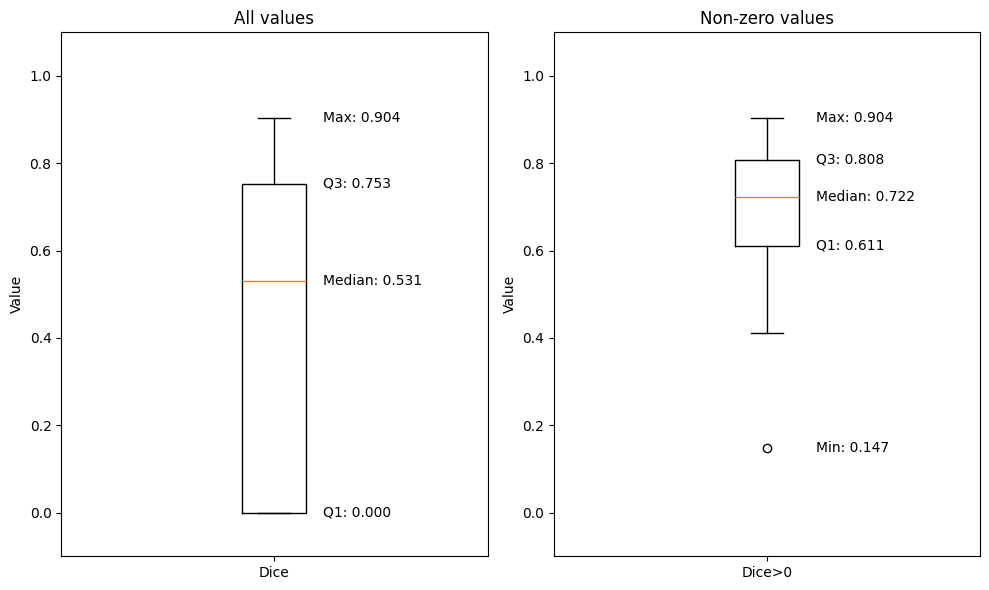

In [9]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display

#read Dice across the project into array.
dice=[]
for scan in ct_scans:
    dcm_path=(Path(xnat_project_path) / scan['path']).parent
    scan_id=Path(scan['path']).parent.parent.stem
    exp_label=Path(scan['path']).parent.parent.parent.parent.stem
    #print(exp_label)
    subject=scan['PatName']
    out_path=outdir / f"{subject}/{exp_label}/{scan_id}/ct"
    try:        
        with open(out_path.parent / "man2AI.json") as txt:
            #print (out_path.parent / "man2AI.json")
            d=json.load(txt)
            #print(d)
        dice+=[d['dice']]
    except Exception as e:
        continue

import numpy as np
import matplotlib.pyplot as plt

dice_arr = np.array(dice, dtype=float)
nonzero = dice_arr[dice_arr != 0]

# ---- STATISTICS ----
print("Count:", len(dice_arr))
print("Mean:", np.mean(dice_arr))
print("Median:", np.median(dice_arr))
print("Min:", np.min(dice_arr))
print("Max:", np.max(dice_arr))
print("Non-zero count:", len(nonzero))
print("Non-zero mean:", np.mean(nonzero) if len(nonzero) else None)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# ---- HARD-CODED Y-LIMITS WITH EXTRA SPACE ----
# Add small margins above 1 and below 0
ymin, ymax = -0.1, 1.1

# ---- FIRST BOX PLOT (all data) ----
axes[0].boxplot(dice_arr, vert=True, showfliers=True)
axes[0].set_title("All values")
axes[0].set_ylim(ymin, ymax)
axes[0].set_xticks([1])
axes[0].set_xticklabels(["Dice"])
axes[0].set_ylabel("Value")

# Annotate percentiles (Q1, median, Q3, max) — no min annotation
p = np.percentile(dice_arr, [25, 50, 75, 100])
labels = ["Q1", "Median", "Q3", "Max"]

for val, lab in zip(p, labels):
    axes[0].annotate(f"{lab}: {val:.3f}",
                     xy=(1.05, val),
                     xytext=(20, 0),
                     textcoords="offset points",
                     va='center')

# ---- SECOND BOX PLOT (non-zero) ----
axes[1].boxplot(nonzero, vert=True, showfliers=True)
axes[1].set_title("Non-zero values")
axes[1].set_ylim(ymin, ymax)
axes[1].set_xticks([1])
axes[1].set_xticklabels(["Dice>0"])
axes[1].set_ylabel("Value")

# Annotate all percentiles including min for non-zero case
p_nz = np.percentile(nonzero, [0, 25, 50, 75, 100])
labels_nz = ["Min", "Q1", "Median", "Q3", "Max"]

for val, lab in zip(p_nz, labels_nz):
    axes[1].annotate(f"{lab}: {val:.3f}",
                     xy=(1.05, val),
                     xytext=(20, 0),
                     textcoords="offset points",
                     va='center')

plt.tight_layout()
plt.show()

